# Imort Libraries

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from shared_code import utils
from pyscbwrapper import SCB
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Initialize Storage Account

In [92]:
azure_utils = utils.AzureUtils()
secret_client = azure_utils.initialize_key_vault()

sa_secret = azure_utils.get_key_vault_secret(secret_client, 'sa-booli')
sa_name = azure_utils.get_key_vault_secret(secret_client, 'sa-name')
storage_account = azure_utils.initialize_storage_account_ad(sa_secret.value, sa_name.value)

# Scraping & Storing Data

## Booli Data

In [ ]:
object_type = "Lägenhet"
minSoldDate = "2022-01-01"
maxSoldDate = "2022-01-02"
rooms = ""
hasBalcony = ""
hasFireplace = ""
hasElevator = ""
area_id = 143

booli_utils = utils.Booli()

data = booli_utils.run_query_sold(object_type, minSoldDate, maxSoldDate, rooms, hasBalcony, hasFireplace, hasElevator, area_id, 1)
total_number_of_pages = data["data"]["search"]["pages"]
total_number_of_objects = data["data"]["search"]["totalCount"]
print(f"Total number of pages: {total_number_of_pages}")

res = []
for page in range(1, total_number_of_pages + 1):
    print(f'Scraping page: {page} / {total_number_of_pages}')
    data = booli_utils.run_query_sold(object_type, minSoldDate, maxSoldDate, rooms, hasBalcony, hasFireplace, hasElevator, area_id, page)
    
    for object in data["data"]["search"]["result"]:
        res.append(object)
    
    print(f"Total number of objects stored {len(res)} / {total_number_of_objects}")
    print("")
    print("--------------------------------------------")
    print("")
    
df = pd.json_normalize(res)

azure_utils.upload_csv_to_datalake(df, "raw/sold/all", f"Sold_{object_type}_{rooms}_{area_id}_{minSoldDate}_{maxSoldDate}.csv")

## Inflation Data

### Inflation By Product

In [208]:
scb = SCB("en")

scb.go_down("PR", "PR0101", "PR0101A", "KPICOI80MN")
products = scb.get_variables()["Product group"]
scb.set_query(ProductGroup = products, observations = "Consumer Price Index (CPI)")
df = pd.DataFrame(scb.get_data()["data"])


In [209]:
df_keys = pd.DataFrame(df["key"].to_list(), columns = ["ProductCode", "Key"])
df_values = pd.DataFrame(df["values"].to_list(), columns = ["CPI"]).replace("..", "").apply(pd.to_numeric)

df_groups = pd.DataFrame(products).T
df_groups.columns = df_keys.ProductCode.unique()
df_groups.columns = df_groups.columns.str.replace(".", "-")

df_productCategory = df_groups.loc[:, ~df_groups.columns.str.contains("-")].T.reset_index()
df_productCategory.columns = ["ProductCode", "Product"]
df_productCategory

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_15516\2843309408.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_groups.columns = df_groups.columns.str.replace(".", "-")


,ProductCode,Product
0,01,Food and non-alcoholic beverages
1,02,Alcoholic beverages and tobacco
2,03,Clothing and footwear
3,04,"Housing, water, electricity, gas and other fuels"
4,05,Furnishings and household goods
5,06,Health
6,07,Transport
7,08,Communication
8,09,Recreation and culture
9,10,Education


In [210]:
df_CPIByProduct = pd.concat([df_keys, df_values], axis = 1)
df_CPIByProduct = df_CPIByProduct.merge(df_productCategory, on = "ProductCode", how = "inner")
df_CPIByProduct = df_CPIByProduct.pivot(index = "Key", columns = "Product", values = "CPI").reset_index().set_index("Key")

df_CPIByProduct.index = df_CPIByProduct.index.str.replace("M", "")
df_CPIByProduct.index = pd.to_datetime(df_CPIByProduct.index, format = "%Y%m")

df_inflationByProduct = df_CPIByProduct.pct_change(periods = 12)

In [211]:
df_CPIByProduct.to_pickle("CPIByProduct.pkl")
df_inflationByProduct.to_pickle("inflationByProduct.pkl")

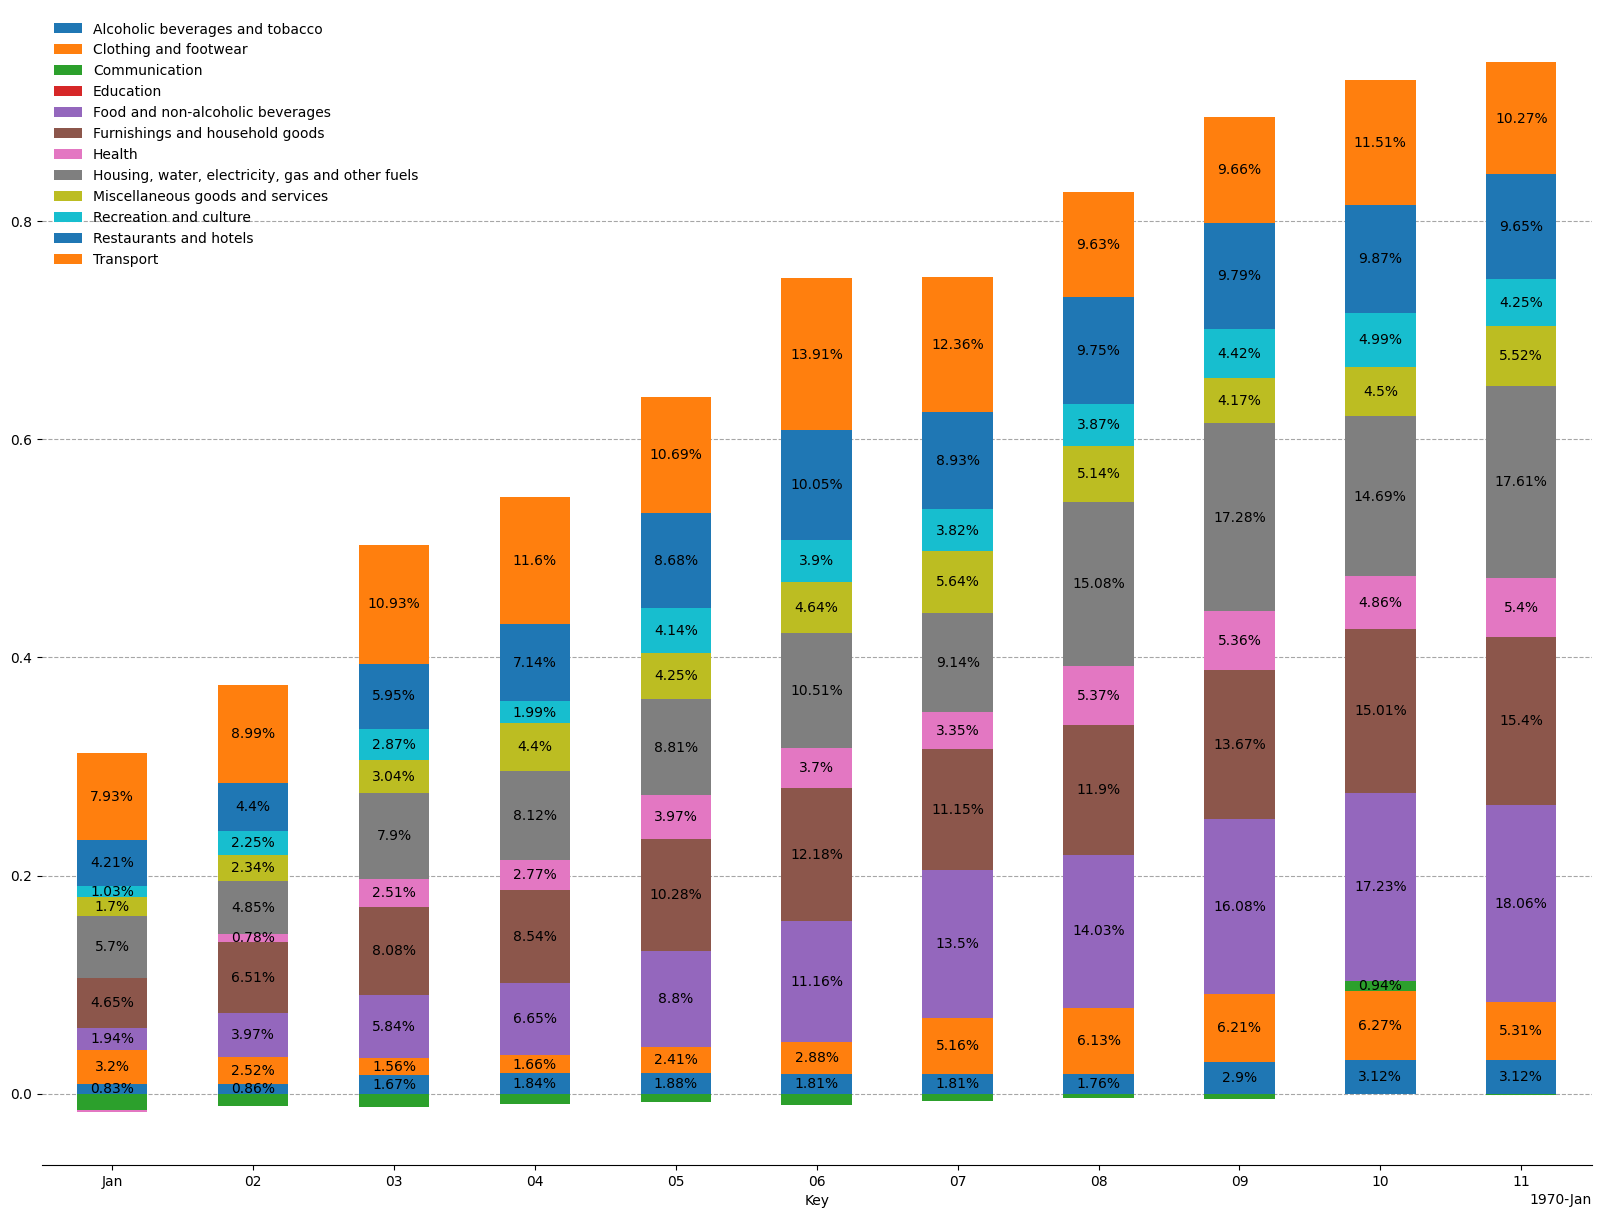

In [212]:
df_plot = df_inflationByProduct[df_inflationByProduct.index.year >= 2022]

ax = df_plot.plot(kind = "bar", stacked = True, figsize = (20, 15), rot = 0)
for c in ax.containers:
    labels = [f"{np.round(v.get_height() * 100, 2)}%" if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels = labels, label_type = "center")
        
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

#grid
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.7)

ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

# plt.setp(ax.get_xticklabels(), rotation=90)

plt.legend(df_plot.columns, frameon = False)

### Total Inflation

In [213]:
scb = SCB("en")

scb.go_down("PR", "PR0101", "PR0101G", "KPIF")
observations = ['CPIF, Index, 1987=100', 'CPIF, monthly changes, 1987=100', 'CPIF, annual changes, 1987=100']
scb.set_query(observations = observations)
data = scb.get_data()["data"]

In [214]:
df = pd.DataFrame(data)

df_keys = pd.DataFrame(df["key"].to_list(), columns = ["key"]).replace("M", "")#df["key"].apply(pd.Series)
df_values = pd.DataFrame(df["values"].to_list(), columns = observations).replace("..", "").apply(pd.to_numeric)#df["values"].apply(pd.Series)
df = pd.concat([df_keys, df_values], axis = 1).set_index("key")
df.index = df.index.str.replace("M", "")
df.index = pd.to_datetime(df.index, format = "%Y%m")
df.tail()

,"CPIF, Index, 1987=100","CPIF, monthly changes, 1987=100","CPIF, annual changes, 1987=100"
key,,,
2022-07-01,242.25,-0.2,8.0
2022-08-01,245.82,1.5,9.0
2022-09-01,248.62,1.1,9.7
2022-10-01,248.32,-0.1,9.3
2022-11-01,250.10,0.7,9.5


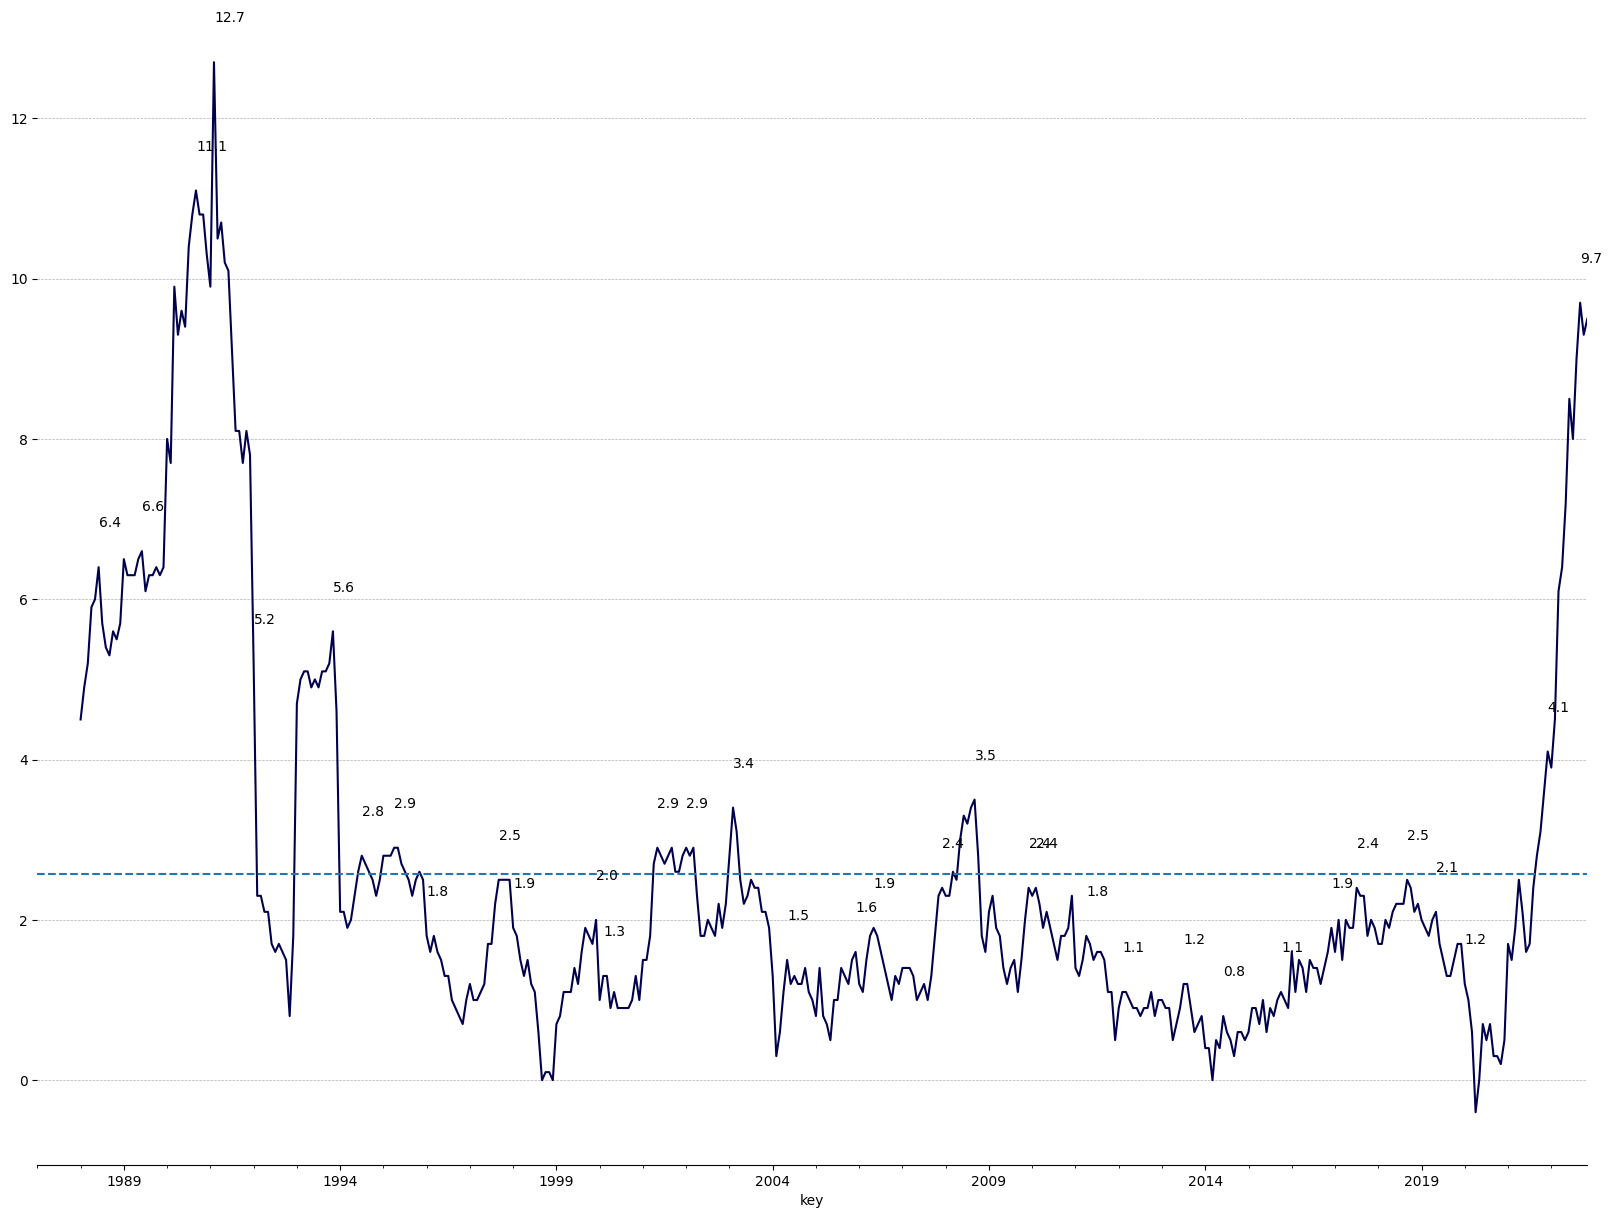

In [215]:
df_plot = df.copy()
df_plot["Year"] = df.index.year
df_plot.columns = ["CPIF_index", "CPIF_monthlyChange", "CPIF_annualChange", "Year"]
df_plot = df_plot[["Year", "CPIF_annualChange"]]

fig, ax = plt.subplots(figsize = (20,15))
df_plot["CPIF_annualChange"].plot(kind = "line", linestyle = "-", color = "#00004d")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()  
ax.grid(axis = "y", linestyle = "--", linewidth = 0.5)

for year in df_plot.Year.unique():
    x_max = df_plot[df_plot.Year == year]["CPIF_annualChange"].idxmax(axis = 0)
    y_max = df_plot[df_plot.Year == year]["CPIF_annualChange"].max()
    
    ax.annotate(f"{y_max}", xy = (x_max, y_max), xytext = (x_max, y_max + 0.5))#, arrowprops = dict(facecolor='black'))
    

ax.axhline(y = np.nanmean(df_plot.CPIF_annualChange), linestyle = "--", label = "Average")
    
plt.show()

In [217]:

df.to_pickle("CPITotal.pkl")

## Subwaystations

In [87]:
url="https://sv.wikipedia.org/wiki/Lista_%C3%B6ver_tunnelbanestationer_i_Stockholm"
df = pd.read_html(url, encoding = "UTF-8")
df = df[1]


### Clean Data

In [88]:
df[["Coordinates_1", "Coordinates_2"]] = df["Position"].str.split(" / ", 1, expand = True)
df[["Longitude", "Latitude"]] = df["Coordinates_2"].str.split(" ", 1, expand = True)
df = df.drop(columns = ["Position", "Coordinates_1", "Coordinates_2"])
df['Longitude']=df.Longitude.str.extract(r"(\d+\.\d+)")
df['Latitude']=df.Latitude.str.extract(r"(\d+\.\d+)")
df = df[["Namn", "Linje", "Longitude", "Latitude"]]
df.columns = ["subwayStationName", "subwayLineName", "latitude", "longitude"]
df = df.astype({"subwayStationName" : str,
                "subwayLineName": str,
                "longitude": float,
                "latitude": float})
df.head()

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_21752\3198717884.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[["Coordinates_1", "Coordinates_2"]] = df["Position"].str.split(" / ", 1, expand = True)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_21752\3198717884.py:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[["Longitude", "Latitude"]] = df["Coordinates_2"].str.split(" ", 1, expand = True)


,subwayStationName,subwayLineName,latitude,longitude
0,Abrahamsberg,Grön,59.336680,17.952950
1,Akalla,Blå,59.414814,17.912796
2,Alby,Röd,59.239498,17.845332
3,Alvik,Grön,59.333633,17.980269
4,Aspudden,Röd,59.306449,18.001447


In [89]:
df.to_pickle("subwayStations.pkl")

## Position Data

In [93]:
df = azure_utils.ingest_raw_data("sold/all/Sold_Lägenhet")
df.head()

,booliId,streetAddress,constructionYear,floor,objectType,descriptiveAreaName,soldPriceType,daysActive,soldDate,latitude,longitude,url,__typename,soldPrice.raw,rent.raw,soldSqmPrice.raw,soldPriceAbsoluteDiff.raw,soldPricePercentageDiff.raw,listPrice.raw,livingArea.raw,rooms.raw,floor.raw,rent,soldPriceAbsoluteDiff,soldPricePercentageDiff,listPrice,rooms,soldSqmPrice,livingArea
0,1297209,Drottningholmsvägen 48,2011.0,NaN,Lägenhet,St Göran,Slutpris,18.0,2012-11-06,59.332038,18.022488,/bostad/342585,SoldProperty,2650000,2193.0,63095.0,0.0,0.0,2650000.0,42.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1309519,Lilla Västerbron 6,2009.0,NaN,Lägenhet,Fredhäll,Slutpris,13.0,2012-11-21,59.331375,18.023321,/annons/1309519,SoldProperty,2650000,2989.0,63095.0,150000.0,6.0,2500000.0,42.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1313807,Igeldammsgatan 20,1932.0,NaN,Lägenhet,St Göran,Slutpris,13.0,2012-11-28,59.336983,18.024736,/annons/1313807,SoldProperty,2110000,1708.0,57027.0,110000.0,5.5,2000000.0,37.0,1.5,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1284962,Hjärnegatan 4,NaN,NaN,Lägenhet,Kungsholmen,Slutpris,13.0,2012-10-17,59.332541,18.042303,/annons/1284962,SoldProperty,2970000,2809.0,54000.0,-30000.0,-1.0,3000000.0,55.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1282231,Vänskapsvägen 55,NaN,NaN,Lägenhet,Stora Essingen,Slutpris,25.0,2012-10-24,59.321561,17.988416,/bostad/792125,SoldProperty,2000000,3698.0,41667.0,-200000.0,-9.1,2200000.0,48.0,2.5,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
df_coordinates = df[["latitude", "longitude"]].drop_duplicates()

In [97]:
geolocator = Nominatim(user_agent = "booli_feature_engineering")
reverse = RateLimiter(geolocator.reverse, min_delay_seconds = 0.1)

df_coordinates["Location"] = df_coordinates.apply(lambda row: reverse(f"{row.latitude}, {row.longitude}"), axis = 1)
df_coordinates.head()

,latitude,longitude,Location
0,59.332038,18.022488,"(Lalibela, Drottningholmsvägen, Stadshagen, Ku..."
1,59.331375,18.023321,"(6, Lilla Västerbron, Marieberg, Kungsholmens ..."


In [105]:
df_coordinates = pd.read_pickle("coordinates.pkl")

In [107]:
df_coordinates.head()

,latitude,longitude,Location,address
booliId,,,,
598032,59.334000,18.023153,"(Sankt Görans sjukhus, Thorildsvägen, Kristine...","{'amenity': 'Sankt Görans sjukhus', 'road': 'T..."
688449,59.372300,18.055624,"(12, Ekhagsvägen, Ekhagen, Norra Djurgården, Ö...","{'house_number': '12', 'road': 'Ekhagsvägen', ..."
692069,59.336461,18.100154,"(6, Gyllenstiernsgatan, Östermalm, Östermalms ...","{'house_number': '6', 'road': 'Gyllenstiernsga..."
796496,59.340750,18.082264,"(62, Nybrogatan, Villastaden, Östermalm, Öster...","{'house_number': '62', 'road': 'Nybrogatan', '..."
871388,59.311852,18.069763,"(6, Möregatan, Skanstull, Södermalm, Södermalm...","{'house_number': '6', 'road': 'Möregatan', 'ne..."


In [106]:
df_coordinates["address"] = df_coordinates.Location.apply(lambda loc: loc.raw["address"] if loc else None)
df_address = df_coordinates.address.apply(pd.Series)
df_address.head()

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_21752\1566363804.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_address = df_coordinates.address.apply(pd.Series)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_21752\1566363804.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_address = df_coordinates.address.apply(pd.Series)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_21752\1566363804.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_address = df_coordinates.address.apply(pd.Series)
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_21752\1566363804.py:4: FutureWarning: The d

,amenity,road,suburb,city_district,city,municipality,county,ISO3166-2-lvl4,postcode,country,country_code,house_number,neighbourhood,shop,residential,highway,building,office,leisure,man_made,healthcare,tourism,craft,commercial,railway,historic,club
booliId,,,,,,,,,,,,,,,,,,,,,,,,,,,
598032,Sankt Görans sjukhus,Thorildsvägen,Kristineberg,Kungsholmens stadsdelsområde,Stockholm,Stockholms kommun,Stockholms län,SE-AB,112 43,Sverige,se,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
688449,NaN,Ekhagsvägen,Norra Djurgården,Östermalms stadsdelsområde,Stockholm,Stockholms kommun,Stockholms län,SE-AB,114 18,Sverige,se,12,Ekhagen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
692069,NaN,Gyllenstiernsgatan,Östermalm,Östermalms stadsdelsområde,Stockholm,Stockholms kommun,Stockholms län,SE-AB,115 26,Sverige,se,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
796496,NaN,Nybrogatan,Östermalm,Östermalms stadsdelsområde,NaN,Stockholms kommun,Stockholms län,SE-AB,114 49,Sverige,se,62,Villastaden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
871388,NaN,Möregatan,Södermalm,Södermalms stadsdelsområde,NaN,Stockholms kommun,Stockholms län,SE-AB,118 58,Sverige,se,6,Skanstull,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
df_address = df_coordinates.merge(df_address, on = "booliId", how = "inner")
df_address.head()

,latitude,longitude,Location,address,amenity,road,suburb,city_district,city,municipality,county,ISO3166-2-lvl4,postcode,country,country_code,house_number,neighbourhood,shop,residential,highway,building,office,leisure,man_made,healthcare,tourism,craft,commercial,railway,historic,club
booliId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
598032,59.334000,18.023153,"(Sankt Görans sjukhus, Thorildsvägen, Kristine...","{'amenity': 'Sankt Görans sjukhus', 'road': 'T...",Sankt Görans sjukhus,Thorildsvägen,Kristineberg,Kungsholmens stadsdelsområde,Stockholm,Stockholms kommun,Stockholms län,SE-AB,112 43,Sverige,se,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
688449,59.372300,18.055624,"(12, Ekhagsvägen, Ekhagen, Norra Djurgården, Ö...","{'house_number': '12', 'road': 'Ekhagsvägen', ...",NaN,Ekhagsvägen,Norra Djurgården,Östermalms stadsdelsområde,Stockholm,Stockholms kommun,Stockholms län,SE-AB,114 18,Sverige,se,12,Ekhagen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
692069,59.336461,18.100154,"(6, Gyllenstiernsgatan, Östermalm, Östermalms ...","{'house_number': '6', 'road': 'Gyllenstiernsga...",NaN,Gyllenstiernsgatan,Östermalm,Östermalms stadsdelsområde,Stockholm,Stockholms kommun,Stockholms län,SE-AB,115 26,Sverige,se,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
796496,59.340750,18.082264,"(62, Nybrogatan, Villastaden, Östermalm, Öster...","{'house_number': '62', 'road': 'Nybrogatan', '...",NaN,Nybrogatan,Östermalm,Östermalms stadsdelsområde,NaN,Stockholms kommun,Stockholms län,SE-AB,114 49,Sverige,se,62,Villastaden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
871388,59.311852,18.069763,"(6, Möregatan, Skanstull, Södermalm, Södermalm...","{'house_number': '6', 'road': 'Möregatan', 'ne...",NaN,Möregatan,Södermalm,Södermalms stadsdelsområde,NaN,Stockholms kommun,Stockholms län,SE-AB,118 58,Sverige,se,6,Skanstull,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
df_address.to_pickle("addresses.pkl")